# Setup

In [1]:
# Imports
import cv2
import copy
import itertools
import keras
import logging
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import re
import scipy.misc
import tensorflow as tf
import time

from scipy import sparse
from scipy import ndimage
from heapq import heappush, heappop
from networkx_viewer import Viewer
from sklearn.feature_extraction import image
from matplotlib import colors as mcolors
from sys import stdout

#%matplotlib inline

Using TensorFlow backend.


# Image to graph

In [2]:
def _make_edges_3d(n_x, n_y, n_z=1):
    """Returns a list of edges for a 3D image.
    Parameters
    ===========
    n_x: integer
        The size of the grid in the x direction.
    n_y: integer
        The size of the grid in the y direction.
    n_z: integer, optional
        The size of the grid in the z direction, defaults to 1
    """
    vertices = np.arange(n_x * n_y * n_z).reshape((n_x, n_y, n_z))
    edges_deep = np.vstack((vertices[:, :, :-1].ravel(),
                            vertices[:, :, 1:].ravel()))
    edges_right = np.vstack((vertices[:, :-1].ravel(),
                             vertices[:, 1:].ravel()))
    edges_down = np.vstack((vertices[:-1].ravel(), vertices[1:].ravel()))
    edges = np.hstack((edges_deep, edges_right, edges_down))
    return edges

In [3]:
def _compute_altitude_3d(edges, img):
    n_x, n_y, n_z = img.shape
    gradient = np.abs(img[edges[0] // (n_y * n_z),
                          (edges[0] % (n_y * n_z)) // n_z,
                          (edges[0] % (n_y * n_z)) % n_z] -
                          img[edges[1] // (n_y * n_z),
                          (edges[1] % (n_y * n_z)) // n_z,
                          (edges[1] % (n_y * n_z)) % n_z])
    return gradient

In [4]:
def img_to_graph(image):
    
    dtype=None
    image = np.atleast_3d(image)
    n_x, n_y, n_z = image.shape
    edges = _make_edges_3d(n_x, n_y, n_z)
    weights = _compute_altitude_3d(edges, image)
    diag = image.ravel()
    n_voxels = diag.size
    diag_idx = np.arange(n_voxels)
    i_idx = np.hstack((edges[0], edges[1]))
    j_idx = np.hstack((edges[1], edges[0]))
    matrix = sparse.coo_matrix((np.hstack((weights, weights, diag)),
                              (np.hstack((i_idx, diag_idx)),
                               np.hstack((j_idx, diag_idx)))),
                              (n_voxels, n_voxels),
                              dtype=dtype)
    graph = nx.from_scipy_sparse_matrix(matrix)
    graph.remove_edges_from(graph.selfloop_edges())
    
    mapping = map_node(image)
    values = get_altitude_map(image)
    
    graph = nx.relabel_nodes(graph, mapping)
    nx.set_node_attributes(graph,'value',values=values)
    
    return graph

In [5]:
def get_altitude_map(img):
    values = dict()
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            values[(row,col)] = img[row,col][0]
    
    return values

In [6]:
def map_node(img):
    
    assert isinstance(img, np.ndarray), "Not an image"
    
    mapping = dict()
    
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            mapping[row * img.shape[1] + col] = ((row), (col))

    return mapping

In [7]:
def get_image_positions(img):
    positions = dict()
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            positions[(row,col)] = (col,row)
    return positions

In [8]:
def view_graph(img, graph, pixel_values=False, 
               figurename='graph.jpg'):
    node_size = 500
    node_color = 'b'
    seed_color = 'r'
    colors = ["pink","orange","brown","red","green",
              "orange","beige","turquoise","blue"]
    
    plt.figure(figsize=(img.shape[0],img.shape[1]))
    
    positions = get_image_positions(img)
          
    pos = nx.spring_layout(graph,pos=positions, fixed = graph.nodes())
    labels = nx.get_edge_attributes(graph, 'altitude')
    

    assigned_nodes = list((n for n in graph if graph.node[n]['seed'] != 'none'))
    unassigned_nodes = list((n for n in graph if graph.node[n]['seed'] == 'none'))

    
    seeds = list((n for n in graph if graph.node[n]['type']=='seed'))
    for x in range(len(seeds)):
        nodes = list((n for n in graph if graph.node[n]['seed']==seeds[x]))
        nx.draw_networkx_nodes(graph,pos,
                       nodelist=nodes,
                       node_color=colors[(x % (len(colors) - 1)) + 1],
                       node_size=node_size,
                   alpha=0.8)
        nx.draw_networkx_nodes(graph,pos,
                       nodelist=seeds,
                       node_size=node_size,
                   alpha=0.8, node_shape= 's')
    
    nx.draw_networkx_nodes(graph,pos,
                       nodelist=unassigned_nodes,
                       node_color=colors[0],
                       node_size=node_size,
                   alpha=0.8)

        
    
    if pixel_values:
        values = nx.get_node_attributes(graph,'value')
        nx.draw_networkx_labels(graph,pos,labels=values)
    else:
        nx.draw_networkx_labels(graph,pos)

    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    nx.draw_networkx_edges(graph,pos , width=5,edge_color='b')
    
    plt.savefig(figurename, dpi=100)
    
    plt.imshow(img, cmap = 'gray')
    
    plt.savefig(figurename, dpi=100)

In [9]:
def plant_seeds(graph, seeds):
    
    temp_graph = graph.copy()
    
    types_dict = dict()
    assignment_dict = dict()
    assignment_history = dict()

    for x in temp_graph.nodes():
        if x in seeds:
            types_dict[x] = "seed"
            assignment_dict[x] = x
            assignment_history[x] = []
        else:
            types_dict[x] = "node"
            assignment_dict[x] = 'none'
            assignment_history[x] = []
        
            
    nx.set_node_attributes(temp_graph, "type", types_dict)
    nx.set_node_attributes(temp_graph, "seed", assignment_dict)
    nx.set_node_attributes(temp_graph, "assignment history", assignment_history)
    
    return temp_graph

In [10]:
def generate_seeds(graph, n_seeds):
    
    seeds = []
    
    for x in range(n_seeds):
        seeds.append(random.choice(graph.nodes()))
        
    return seeds

In [11]:
def get_graph(window_size, window_tl, image):
    
    fname = "Saved_Graphs/graph_{}_{}_{}_{}.p".format(window_tl[0],window_tl[1],window_size[0],window_size[1])
    
    #if graph already exists, load graph
    if os.path.isfile(fname):
        
        print("Retrieveing graph.")
        graph = nx.read_gpickle(fname)
        
    #else, build the graph    
    else:
        
        print("Graph doesn't exist. Creating graph.")
        #Translate image to 4 connected grid graph
        graph = img_to_graph(image)
        nx.write_gpickle(graph,fname)
        
    return graph

In [12]:
def get_graph_seed_assignments(graph):
    assignments = dict()
    for a, seed in enumerate(seeds):
        nodes = list((n for n in graph if graph.node[n]['seed']==seeds[a]))
        assignments.update(dict.fromkeys(nodes, a))
    return assignments

In [13]:
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return np.array([(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors])

In [14]:
def projections(graph, seed, image):
    '''This will output the relative labelings and save the RGB image to the relative labelings folder'''
    
    positions = get_image_positions(image)
    assignments = get_graph_seed_assignments(graph)
    
    seeds = set(assignments.values())
    n_seeds = len(seeds)
    
    seed_colors = get_spaced_colors(n_seeds)
    
    mask = np.zeros((image.shape[0], image.shape[1], 3))
    
    s = pd.Series(assignments)
    s = s.values.reshape(image.shape)
    
    for x in range(n_seeds):
        a = s == x
        if x == seed:
            mask[a] = [0, 255, 0]
        else:
            mask[a] = [0, 0, 255]
    return mask

In [15]:
def prims_msf(G):
    iters = []
    MSF = nx.Graph()
    nodes = G.nodes()
    s = filter(lambda (n, d): d['type'] == 'seed', G.nodes(data=True))
    seeds = []
    iteration = itertools.count(1)
    num_edges = G.number_of_edges()
    for x in s:
        seeds.append(x[0])
    push = heappush
    pop = heappop

    while nodes:
        frontier = []
        visited = []
        for u in seeds:
            nodes.remove(u)
            visited.append(u)
            
            # Add seed to MSF
            MSF.add_node(u, attr_dict=G.node[u])
            
            # Push all edges
            for u, v in G.edges(u):
                
                stdout.write("\rCalculating edge {}/{}".format(next(iteration), num_edges))
                stdout.flush()
                
                push(frontier, (G[u][v].get('weight', 1), u, v))
        
        

        while frontier:
            W, u, v = pop(frontier)   

            if v in visited:
                continue
            
            # Assign the node
            G.node[v]['seed'] = G.node[u]['seed']
            
            # Add node and edge to MSF
            MSF.add_node(v,attr_dict=G.node[v])
            MSF.add_edge(u,v,attr_dict=G.edge[u][v])
            
            G.node[G.node[u]['seed']]['assignment history'] = G.node[G.node[u]['seed']]['assignment history'] + [v]       
            
            visited.append(v)
            nodes.remove(v)
            for v, w in G.edges(v):
                if not w in visited:
                    
                    stdout.write("\rCalculating edge {}/{}".format(next(iteration), num_edges))
                    stdout.flush()
                    
                    push(frontier, (G[v][w].get('weight', 1), v, w))
    return MSF

In [16]:
def field_of_view(master_image, center_pixel, crop_size):
    """Returns a crop of the master image centered on a specified pixel.
    
    Args:
        master_image (numpy.ndarray): The master image to be cropped.
        center_pixel (tuple): The pixel to be at the center of the crop.
        window_size (tuple): The dimensions of the newly cropped image.
        
    Returns:
        A cropped image of the master image with the specified pixel at the center.
        
    Examples:
        fov = field_of_view(I, (0,0), (50,50))"""
    
    center = (center_pixel[0] + crop_size[0], center_pixel[1] + crop_size[1])

    t_l = (center[0] - crop_size[0] // 2, center[1] - crop_size[1] // 2)
    
    return master_image[t_l[0]:t_l[0] + crop_size[0],t_l[1]:t_l[1] + crop_size[1],:]

In [17]:
def assignment_mask(image, graph):
    positions = get_image_positions(image)
    assignments = get_graph_seed_assignments(graph)
    
    seeds = set(assignments.values())
    n_seeds = len(seeds)
    
    seed_colors = get_spaced_colors(n_seeds)
    
    mask = np.zeros((image.shape[0], image.shape[1], 3))
    
    s = pd.Series(assignments)
    s = s.values.reshape(image.shape)
    
    for x in range(n_seeds):
        a = s == x
        mask[a] = seed_colors[x]
    return mask

In [18]:
def max_arc_topographical_distance(path, graph):
    """Returns the max-arc topographical distance of a path in a graph.
    
    Args:
        path (list): A list of tuples defining the path traversed in graph.
        graph (networkx.classes.graph.Graph): The graph containing the path.
        
    Returns:
        float: the max-arc topographical distance of path."""

    
    G = graph.subgraph(path)
    
    distance = -np.infty
    
    for x, y in G.edges_iter():
        altitude = G.edge[x][y]['altitude']
        if altitude > distance:
            distance = altitude
            edge = (x, y)
            
    return distance, edge

In [19]:
def get_boundary_probabilities(img):
    """Returns boundary probabilites for an image"""
    
    #Make a placeholder for boundary probabilities coming in next iteration of pipeline
    return np.random.rand(img.shape[0],img.shape[1])

In [20]:
def _AsList(x):
    return x if isinstance(x, (list, tuple)) else [x]

In [21]:
def prims_on_demand(G, image_dict):
    """
    Creates a minimum spanning forest from give graph.
    
    Args:
        G (Graph): Graph to use for minimum spanning forest.
        image_dict (Dictionary): The dictionary of nodes used to calculate an altitude.
        
    Returns:
        MSF (Graph): Minimum spanning forest.
    """
    
    MSF = nx.Graph()
    nodes = G.nodes()
    
    s = filter(lambda (n, d): d['type'] == 'seed', G.nodes(data=True))
    seeds = []
    
    node_used = dict()
    
    iteration = itertools.count(1)
    
    for x in s:
        seeds.append(x[0])
        
    push = heappush
    pop = heappop
    
    num_edges = G.number_of_edges()

    while nodes:
        
        frontier = []
        visited = []
        
        for u in seeds:
            nodes.remove(u)
            visited.append(u)
            
            # Add seed to MSF
            MSF.add_node(u, attr_dict=G.node[u])
            
            # Push all edges
            for u, v in G.edges(u):
                
                stdout.write("\rCalculating edge {}/{}".format(next(iteration), num_edges))
                stdout.flush()
                
                # Fetch cropped image from dictionary
                fov = image_dict[(v[0], v[1])]
                
                # Calculate newly discovered edge altitude
                x = np.expand_dims(fov, axis=0)
                
                with sess.as_default():
                    altitude = sess.run(f_static, feed_dict={image_placeholder: x,
                                                             keras.backend.learning_phase(): 0})
                G.edge[u][v]['altitude'] = altitude[0][0]
                G.edge[u][v]['f_static_image'] = fov
                G.edge[u][v]['f_dynamic_image'] = fov

                push(frontier, (altitude, u, v))
        
        

        while frontier:
            W, u, v = pop(frontier)   
            
            if v in visited:
                continue
            
            # assign the node
            G.node[v]['seed'] = G.node[u]['seed']
            
            # add node and edge to MSF
            MSF.add_node(v,attr_dict=G.node[v])
            MSF.add_edge(u,v,attr_dict=G.edge[u][v])
            G.node[G.node[u]['seed']]['assignment history'] = \
            G.node[G.node[u]['seed']]['assignment history'] + [v]       
            
            visited.append(v)
            nodes.remove(v)
            for v, w in G.edges(v):
                if not w in visited:
                    stdout.write("\rCalculating edge {}/{}".format(next(iteration), num_edges))
                    stdout.flush()
                    
                    # Fetch cropped image from dictionary
                    fov = image_dict[(w[0], w[1])]
                    
                    # Calculate newly discovered edge altitude
                    x = np.expand_dims(fov, axis=0)
                    with sess.as_default():
                        altitude = sess.run(f_static, feed_dict={image_placeholder: x,
                                                             keras.backend.learning_phase(): 0})
                    G.edge[v][w]['altitude'] = altitude[0][0]
                    G.edge[v][w]['f_static_image'] = fov
                    G.edge[v][w]['f_dynamic_image'] = fov
                
                    push(frontier, (altitude, v, w))
                    
    stdout.write("\n")
    
    return MSF

In [22]:
def epoch_data(img_graph):
    """
    Returns arrays containing edge calculation images and edge children count.
    
    Each edge weight corresponds to the same image used to calculate the edge.  For example,
    if images[0] was used to compute edge ((0,0),(0,1)), then weights[0] would be the error
    weight for that same edge.
    
    Args:
        img_graph: (graph)
    
    Returns:
        images (list): A list in which each element is the `ndarray` used to compute the
        edge in the graph.
        weights: (list): A list in which each element is the error weight for the edge.
    """
    
    
    images = list()
    weights = list()

    for edge in img_graph.edges_iter():
        try:
            weights.append(img_graph.edge[edge[0]][edge[1]]['error_weight'])
            images.append(img_graph.edge[edge[0]][edge[1]]['f_static_image'])
            
        except KeyError:
            #weights.append(0)
            continue

    images = np.array(images)
    weights = np.array(weights)
    
    return images, weights

In [23]:
def create_batches(data, batch_size=32):
    """
    Split data into batches of a specific size.  If there is a remainder of data,
    the last batch might be smaller.
    
    Args:
        data (numpy.ndarray):  Data to be split into batches.
        batch_size (int): Size of batches.
    
    Returns:
        batches (list): A list of batches (or numpy arrays), each the specified batch size. 
        
    Examples:
        >>> batches = create_batches(x_train, 32)
    """
    
    batches = list()
    
    while data.shape[0] >= batch_size:
        batches.append(data[0:batch_size,:,:,:])
        data = np.delete(data, range(0,batch_size), 0)

    batches.append(data[0:data.shape[0],:,:,:])
    data = np.delete(data, range(0,data.shape[0]), 0)
    
    return batches

In [24]:
def create_list_batches(data, batch_size=32):
    """
    Creates a list of batches from a given list.
    
    Args:
        input_list (list): The input list to be split into batches.
        
    Returns:
        list: a list of batches.
    """
    
    batches = list()
    
    while data.shape[0] >= batch_size:
        batches.append(data[0:batch_size])
        data = np.delete(data, range(0,batch_size), 0)

    batches.append(data[0:data.shape[0],])
    data = np.delete(data, range(0,data.shape[0]), 0)
    
    return batches

In [25]:
def manually_check_loss(images, weights):
    """
    Checks the loss of the given data.
    """
    
    loss = 0

    with sess.as_default():
        altitudes = sess.run(f_static, feed_dict={image_placeholder: images,
                                                  keras.backend.learning_phase(): 0})
        
        loss = np.dot(weights, altitudes)
        
        print altitudes
    
    return loss

In [26]:
def find_deviation(ground_truth_path, shortest_path):
    """
    Computes finds the edge where the ground truth path deviates from the shortest path.

    Args:
        ground_truth_path (list): The list of edges in the ground truth path.
        shortest_path (list): The list of edges in the shortest path.

    Returns:
        tuple: The first edge in which the two paths differ.
    """

    for i, (ground_truth_node, shortest_path_node) in enumerate(zip(ground_truth_path, shortest_path)):
        
        #print i, (ground_truth_node, shortest_path_node)
        
        if shortest_path_node != ground_truth_node:
            return (ground_truth_path[i - 1], ground_truth_path[i])
    else:
        raise ValueError('No deviation.')

In [27]:
def find_first_false_cut(ground_truth_path, ground_truth_cuts, cut_edges):
    """
    Finds the first false cut edge of a ground truth path.
    
    
    Args:
        ground_truth_path (list): A list of nodes representing the path from the seed to the node.
        ground_truth_cuts (list): A list of ground truth cut edges. 
        cut_edges (list): A list of cut edges from the minimum spanning forest.
        
    Returns:
        tuple: The first edge in the ground truth path that is in the list of cut edges, but not in
        in the list of ground truth edges.
    """
    
    #print ground_truth_path
    #print ground_truth_cuts
    #print cut_edges
    
    for i, node in enumerate(ground_truth_path):
        try:
            edge = (ground_truth_path[i], ground_truth_path[i + 1])
            if edge in cut_edges or tuple(reversed(edge)) in cut_edges:
                if edge not in ground_truth_cuts or tuple(reversed(edge)) not in ground_truth_cuts:
                    return edge

        except IndexError:
            print "Something went wrong."
            continue


In [28]:
def compute_root_error_edge_children(msf, constrained_msf, cut_edges, ground_truth_cuts):
    """
    Computes the root error edges used for a single training epoch of the system.

    This function will prepare the weight function and the altitude prediction used for the loss.
    The approach taken here is for every node in the graph, check if the node satisfies a failure 
    condition. If so, then add or subtract to the root error edge children.           

    By construction of the MSF, the shortest path and the ground truth path are equal
    for all nodes.  Conversely, they differ for incorrect nodes, causing the gound truth
    path distance to exceed the shortest path distance.

    TODO:
        Write function to fetch root error false cuts.
    """

    # Create a counter for correct nodes.
    correct_nodes = 0
    
    # Initialize edge error weights dictionary.
    edge_error_weights = dict()
    
    # Create a list of nodes and iterate through them.
    nodes = list((n for n in msf if msf.node[n]['type']=='node'))

    for node in nodes:

        # Get assigned seeds for MSF and constrained MSF.
        assigned_seed = msf.node[node]['seed']
        ground_truth_seed = constrained_msf.node[node]['seed']

        # Get the path from seed to node
        shortest_path = next(nx.all_simple_paths(msf, assigned_seed, node))
        ground_truth_path = next(nx.all_simple_paths(constrained_msf, ground_truth_seed, node))
        
        # Get the distances from the seed to the node.
        shortest_path_distance, shortest_distance_edge = max_arc_topographical_distance(shortest_path,
                                                                                        msf)
        ground_truth_path_distance, ground_truth_distance_edge = \
                                    max_arc_topographical_distance(ground_truth_path,
                                                                   constrained_msf)

            
        # Check is the ground truth path and the shortest path are equivalent.  If so, 
        #  then the node is correct, if not, then the node is incorrect.  
        if shortest_path == ground_truth_path:
            
            # Increment the number of correct nodes for segmentation accuracy.
            correct_nodes += 1      
            
        else:
            
            # The node is incorrect.  Compute the root edge to increase (p(w)).
            root_missing_cut_edge = find_missing_cut(shortest_path, ground_truth_cuts, 
                                                     cut_edges)
            

            # Increment the number of children for the root edge.
            try:
                edge_error_weights[root_missing_cut_edge]
                
            except KeyError:
                
                edge_error_weights[root_missing_cut_edge] = 0
            finally:
                
                edge_error_weights[root_missing_cut_edge] = \
                edge_error_weights[root_missing_cut_edge] - 1
            

    print "Correct nodes: {}/{}".format(correct_nodes, msf.number_of_nodes()) 

    # Once all nodes have been iterated through, set the edge weights in the graph.

    return edge_error_weights

In [29]:
def view_boundary_line(image, graph, figurename="graph.jpg"):
    """
    Draws the segmentation boundary line on the image for the given graph.
    
    Args:
        graph: The graph to use to compute the boundary lines.
        figurename: The name of the image to be saved to the current working directory.
    """
    
    boundary_nodes = list()
    
    seeds = list((n for n in graph if graph.node[n]['type']=='seed'))
    boundary_nodes.extend(seeds)
    
    for edge in graph.edges_iter():            
        if graph.node[edge[0]]['seed'] is not graph.node[edge[1]]['seed']:
            boundary_nodes.extend([edge[0], edge[1]])
            
    sub_graph = graph.subgraph(boundary_nodes)
    view_graph(image, sub_graph, figurename=figurename)

In [30]:
def find_missing_cut(shortest_path, ground_truth_cuts, cut_edges):
    """
    Computes the root error missing cut of a shortest path.

    Every incorrect shortest path has at least one erroneous cut edge.  The first such
    edge shall be called the path's root error edge p(w) and is always a missing cut.

    Args:
        shortest_path (list): The list of edges in the shortest path.
        ground_truth_cuts (list): The list ground truth cuts for the ground truth segmentation.
        cut_edges (list): The list of cut edges from the current segmentation.

    Returns:
        tuple: The first erroneous cut edge in the shortest path.
    """

    for i, node in enumerate(shortest_path):
        try:
            edge = (shortest_path[i], shortest_path[i + 1])
            if edge in ground_truth_cuts or tuple(reversed(edge)) in ground_truth_cuts:
                if edge not in cut_edges and tuple(reversed(edge)) not in cut_edges:
                    return edge

        except IndexError:
            print "Something went wrong."
            continue

In [31]:
class Watershed:
    
    def __init__(self, window_size=(32,32)):
        self.window_size = window_size
    
    def fit(self, images, ground_truth_images, epochs=16, batch_size=32, verbose=False):
        """
        Fits the model given an image or set of images.
        
        Args:
            images: A `numpy.ndarray` or list of arrays to be used to fit the model.
            ground_truth_images: A `numpy.ndarray` or list of arrays to be used to fit the model.
        """
        
        self.verbose=verbose
        self.epochs = epochs
        self.images = _AsList(images)
        self.ground_truth_images = _AsList(ground_truth_images)
        
        for image, ground_truth_image in zip(self.images, self.ground_truth_images):
            self.image = image
            self.ground_truth_image = ground_truth_image
            self._train_single()
        
    def _train_single(self):
        """
        Trains the model on a single image. Training is composed of two steps. First the image is
        segmented. Second, the model is updated. Before the model is trained, the ground truth
        cut edges are calculated.
        """
        
        print "Computing ground truth cuts."
        
        self.ground_truth_cuts = self._compute_ground_truth_cuts(self.ground_truth_image,
                                                                 self.seeds)
        #view_boundary_line(self.ground_truth_image, self.ground_truth_graph,
        #           figurename="ground_truth_msf.jpg")
        
        ground_truth_segmentation = assignment_mask(w.image, w.ground_truth_graph)
        filename = "ground_truth_segmentation.jpg"
        cv2.imwrite(filename, ground_truth_segmentation)
        
        self.loss_timeline = list()
        
        for i in xrange(self.epochs):
            self.current_epoch = i + 1
            print "\n==========="
            print "Epoch ", self.current_epoch
            print "==========="
            
            print "1. Computing the MSF and constrained MSF"
            segmentation = self.segment(self.image)
            
            if self.verbose:
                filename = "epoch_{}.jpg".format(self.current_epoch)
                cv2.imwrite(filename, segmentation)
            
            loss_val = self._training_epoch()
            
            print "Loss: ", loss_val
        

    def segment(self, image):
        """
        Segments image.
        
        TODO:
            Create and return segmented image.
        """
        
        self._prepare_input_images()
        
        # Translate image to 4 connected grid graph.
        self.image_graph = img_to_graph(image)
            
        # Plant seeds.
        self.image_graph = plant_seeds(self.image_graph, self.seeds)
        
        # Compute image MSF.
        self.image_msf =  prims_on_demand(self.image_graph, self.input_images)

        # Compute cut edges
        self.cut_edges = []
        
        [self.cut_edges.append(e) if self.image_msf.node[e[0]]['seed']\
        is not self.image_msf.node[e[1]]['seed'] else '' for e in\
        self.image_graph.edges_iter()]
            
        return assignment_mask(image, self.image_graph)
        
    def _training_epoch(self):
        """
        This is the training epoch for each image.  The approach taken here is to first 
        create the constrained msf with the ground truth cut edges, then compute
        the root error edges, afterwards compute and apply the updates for the model parameters.
        """
        
        # Compute the constrained MSF.
        self.constrained_msf = self._compute_constrained_msf()
        
        print "2. Identifying root edges and loss."
        edge_error_weights = compute_root_error_edge_children(self.image_msf, self.constrained_msf,
                                                                 self.cut_edges, self.ground_truth_cuts)
        
        print edge_error_weights
        
        nx.set_edge_attributes(self.image_graph, 'error_weight', edge_error_weights)
        
        # Fetch the training data from the image graph.
        images, weights = epoch_data(self.image_graph)
        
        # Compute loss.
        with sess.as_default():
            loss_val = sess.run(loss, feed_dict={image_placeholder: images,
                                                 gradient_weights: [weights],
                                                 keras.backend.learning_phase(): 0})
        loss_val = loss_val[0][0]
        
        # Sanity check for the loss.\n",
        manual_loss = manually_check_loss(images, weights)
        print "Manually checked loss: ", manual_loss
            
        # Update parameters
        with sess.as_default():
            sess.run(update_step, feed_dict={image_placeholder: images,
                                             gradient_weights: [weights],
                                             keras.backend.learning_phase(): 0})
            
        return loss_val
    
    
    def _compute_ground_truth_cuts(self, ground_truth_image, seeds):
        """
        Computes the ground truth cuts of the given image.
        
        Args:
            ground_truth_image (ndarray): The image used to create the ground truth cuts.
            seeds (list): A list of seeds to start watershed.
        
        Returns:
            list: A list of ground truth cut edges.
        """
        
        self.ground_truth_graph = img_to_graph(ground_truth_image)
        self.ground_truth_graph = plant_seeds(self.ground_truth_graph, self.seeds)
        self.ground_truth_msf = prims_msf(self.ground_truth_graph)
        
        # Compute the ground truth cut edges
        ground_truth_cuts = []
        [ground_truth_cuts.append(e) if self.ground_truth_msf.node[e[0]]['seed']\
                 is not self.ground_truth_msf.node[e[1]]['seed'] else '' for e in\
                 self.ground_truth_graph.edges_iter()]
        
        return ground_truth_cuts
            

    def _prepare_input_images(self):
        """
        Preprocess images to be used in the prediction of the edges.
        """
        
        self.padded_image = np.pad(self.image,(self.window_size [0],self.window_size [1]),'reflect')
        
        #boundary_probabilities = get_boundary_probabilities(self.padded_image)
        boundary_probabilities = np.pad(self.ground_truth_image,(self.window_size [0],self.window_size [1]),'reflect')

        #Augment the image with boundary probabilities
        self.augmented_image = np.dstack((self.padded_image, boundary_probabilities))

        # Get input images
        self.input_images = dict()

        for x in range(self.image.shape[0]):
            for y in range(self.image.shape[1]):
                node = (x, y)
                self.input_images[node] = field_of_view(self.augmented_image, node, self.window_size)

        
    def _compute_constrained_msf(self):
        """
        Returns the constained msf.
        
        """
        
        self.img_cuts = self.image_graph.copy()
        self.img_cuts.remove_edges_from(self.ground_truth_cuts)
        return prims_on_demand(self.img_cuts, self.input_images)
    
    
    @property
    def ground_truth_cuts(self):
        return self.ground_truth_cuts
    
    
    @property
    def cut_edges(self):
        return self.cut_edges
    
    @property
    def image_msf(self):
        return self.image_msf
    
    
    @property
    def image_graph(self):
        return self.image_graph
    
    
    @property
    def seeds(self):
        return self.seeds
    
    
    @seeds.setter
    def seeds(self, seeds):
        self.seeds = seeds
        
    
    @property
    def window_size(self):
        return self.window_size
    
    @property
    def image_dict(self):
        return self.image_dict
    
    
    @property    
    def root_missing_cuts(self):
        """
        Returns the root missing cuts list used for the loss of the model.
        
        TODO:
            Actually compute the correct values and don't use the dummy values.
        """
        
        return self.root_edges_list
    
    @property    
    def root_false_cuts(self):
        """
        Returns the root false cuts list used for the loss of the model.
        
        TODO:
            Actually compute the correct values and don't use the dummy values.
        """
        
        self.root_edges_list = [int(random.randint(-1,1)) for i in xrange(num_of_edges)]
        
        return self.root_edges_list

# THIS IS THE START OF THE COMPUTATION

In [32]:
# Set image size
image_tl = (0, 0)
image_size = (252, 252)
window_size = (15, 15)

#import Images
img = cv2.imread('1O.jpg', 0)
gt = cv2.imread('1G.jpg', 0)

#resize
img = img[image_tl[0]:image_tl[0] + image_size[0],
          image_tl[1]:image_tl[1] + image_size[1]]
gt = gt[image_tl[0]:image_tl[0] + image_size[0],
        image_tl[1]:image_tl[1] + image_size[1]]

#set type
img = img.astype(np.int16)
gt = gt.astype(np.int16)

# Save image
plt.imsave("image", cv2.resize(img, (1000,1000)), cmap='gray')
plt.clf()

# Import seeds
seeds = []
f = open("seeds1G.txt", 'r')
for line in f:
    x = int(float(re.split(' ', line)[0]))
    y = int(float(re.split(' ', line)[1]))
    seed = (x, y)
    
    

    if x >= image_tl[0] and x <= image_tl[0] + image_size[0]:
        if y >= image_tl[1] and y <= image_tl[1] + image_size[1]:
            x = x - image_tl[0]
            y = y - image_tl[1]
            seed = (x, y)
            seeds.append(seed)

In [33]:
# This placeholder will contain the input images
image_placeholder = tf.placeholder(tf.float32, shape=(None, window_size[0], window_size[0], 2))

# Create model
m = keras.layers.Conv2D(16, 5, padding = 'same',
                 activation='elu', dilation_rate=1) (image_placeholder)
m = keras.layers.Conv2D(16, 3, padding = 'same',
                 activation='elu', dilation_rate=1) (m)
m = keras.layers.BatchNormalization() (m)
m = keras.layers.Conv2D(32, 3, padding = 'same',
                 activation='elu', dilation_rate=2) (m)
m = keras.layers.BatchNormalization() (m)
m = keras.layers.Conv2D(32, 3, padding = 'same',
                 activation='elu', dilation_rate=4) (m)
m = keras.layers.BatchNormalization() (m)
m = keras.layers.Conv2D(64, 3, padding = 'same',
                 activation='elu', dilation_rate=8) (m)
m = keras.layers.BatchNormalization() (m)
m = keras.layers.Conv2D(64, 3, padding = 'same',
                 activation='elu', dilation_rate=16) (m)
m = keras.layers.BatchNormalization() (m)
m = keras.layers.Conv2D(128, 3, padding = 'same',
                 activation='elu', dilation_rate=1) (m)
m = keras.layers.BatchNormalization() (m)
m = keras.layers.Flatten()(m)
m = keras.layers.Dense(32, activation='relu')(m)
m = keras.layers.BatchNormalization() (m)
m = keras.layers.Dense(1, activation='elu')(m)
f_static = keras.layers.BatchNormalization() (m)

In [ ]:
# This placeholder will hold the root error edge values.
gradient_weights = tf.placeholder(tf.float32, shape=(1, None))

# Define optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)

loss = tf.matmul(gradient_weights, f_static)

# Compute gradients of predictions with respect to the parameters.
grads_and_vars = opt.compute_gradients(loss, tf.trainable_variables())

# Clip the gradients
#capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in grads_and_vars]

# Apply gradients
update_step = opt.apply_gradients(grads_and_vars)

sess = tf.Session() 
sess.run(tf.global_variables_initializer())

In [ ]:
logging.shutdown()
logging.basicConfig(filename='example.log', filemode='w', level=logging.DEBUG)
plt.clf()

w = Watershed(window_size=window_size)

w.seeds = seeds

w.fit(img, gt, epochs=5, verbose=True)

Computing ground truth cuts.
Calculating edge 126504/126504
Epoch  1
1. Computing the MSF and constrained MSF
Calculating edge 65097/126504

In [ ]:
# Set image size
image_tl = (100,100)
image_size = (252, 252)
window_size = (15, 15)

#import Images
img = cv2.imread('1O.jpg', 0)
gt = cv2.imread('1G.jpg', 0)

#resize
img = img[image_tl[0]:image_tl[0] + image_size[0],
          image_tl[1]:image_tl[1] + image_size[1]]
gt = gt[image_tl[0]:image_tl[0] + image_size[0],
        image_tl[1]:image_tl[1] + image_size[1]]

#set type
img = img.astype(np.int16)
gt = gt.astype(np.int16)

# Save image
plt.imsave("image", cv2.resize(img, (1000,1000)), cmap='gray')
plt.clf()

# Import seeds
seeds = []
f = open("seeds1G.txt", 'r')
for line in f:
    x = int(float(re.split(' ', line)[0]))
    y = int(float(re.split(' ', line)[1]))
    seed = (x, y)
    
    

    if x >= image_tl[0] and x <= image_tl[0] + image_size[0]:
        if y >= image_tl[1] and y <= image_tl[1] + image_size[1]:
            x = x - image_tl[0]
            y = y - image_tl[1]
            seed = (x, y)
            seeds.append(seed)

In [ ]:
w.seeds = seeds

segmentation = w.segment(img)


filename = "test.jpg"
cv2.imwrite(filename, segmentation)

# THIS IS THE END OF THE COMPUTATION

In [110]:
images, weights = epoch_data(w.image_graph)
print len(images), len(weights)

17 17


In [111]:
with sess.as_default():
    var = sess.run(tf.trainable_variables())
var[0]

array([[[[ -3.41513008e-02,  -9.71095785e-02,   2.25662291e-02,
            7.95707107e-04,  -1.17176771e-03,   1.20525807e-02,
           -7.07943588e-02,  -9.30542126e-02,  -9.03826058e-02,
            1.02804944e-01,  -5.24863079e-02,  -7.26431608e-02,
           -1.15286946e-01,  -1.12949535e-02,   6.63001686e-02,
            4.01472747e-02],
         [  1.11637428e-01,   1.04573756e-01,   5.63781410e-02,
           -8.63177106e-02,  -1.04782000e-01,  -6.87492564e-02,
           -6.07906580e-02,   7.38899112e-02,  -1.55504942e-02,
            5.21897823e-02,   8.00848007e-03,   5.52116036e-02,
           -2.89926082e-02,  -1.08931080e-01,   8.92451406e-02,
           -2.44531557e-02]],

        [[ -1.15664303e-02,  -7.08718076e-02,  -7.71124363e-02,
            1.53243542e-02,   3.56734693e-02,   5.95562607e-02,
           -8.15390199e-02,   8.40249062e-02,  -9.65455696e-02,
           -3.82978991e-02,   7.00231940e-02,   9.51641798e-02,
           -7.24514127e-02,   7.48162866e-02

In [113]:
with sess.as_default():
    g_and_v = sess.run(grads_and_vars, feed_dict={image_placeholder: images,
                                                  gradient_weights: np.expand_dims(weights, axis=0),
                                                  keras.backend.learning_phase(): 0})
g_and_v[0][0]

TypeError: Fetch argument None has invalid type <type 'NoneType'>

KeyboardInterrupt: 

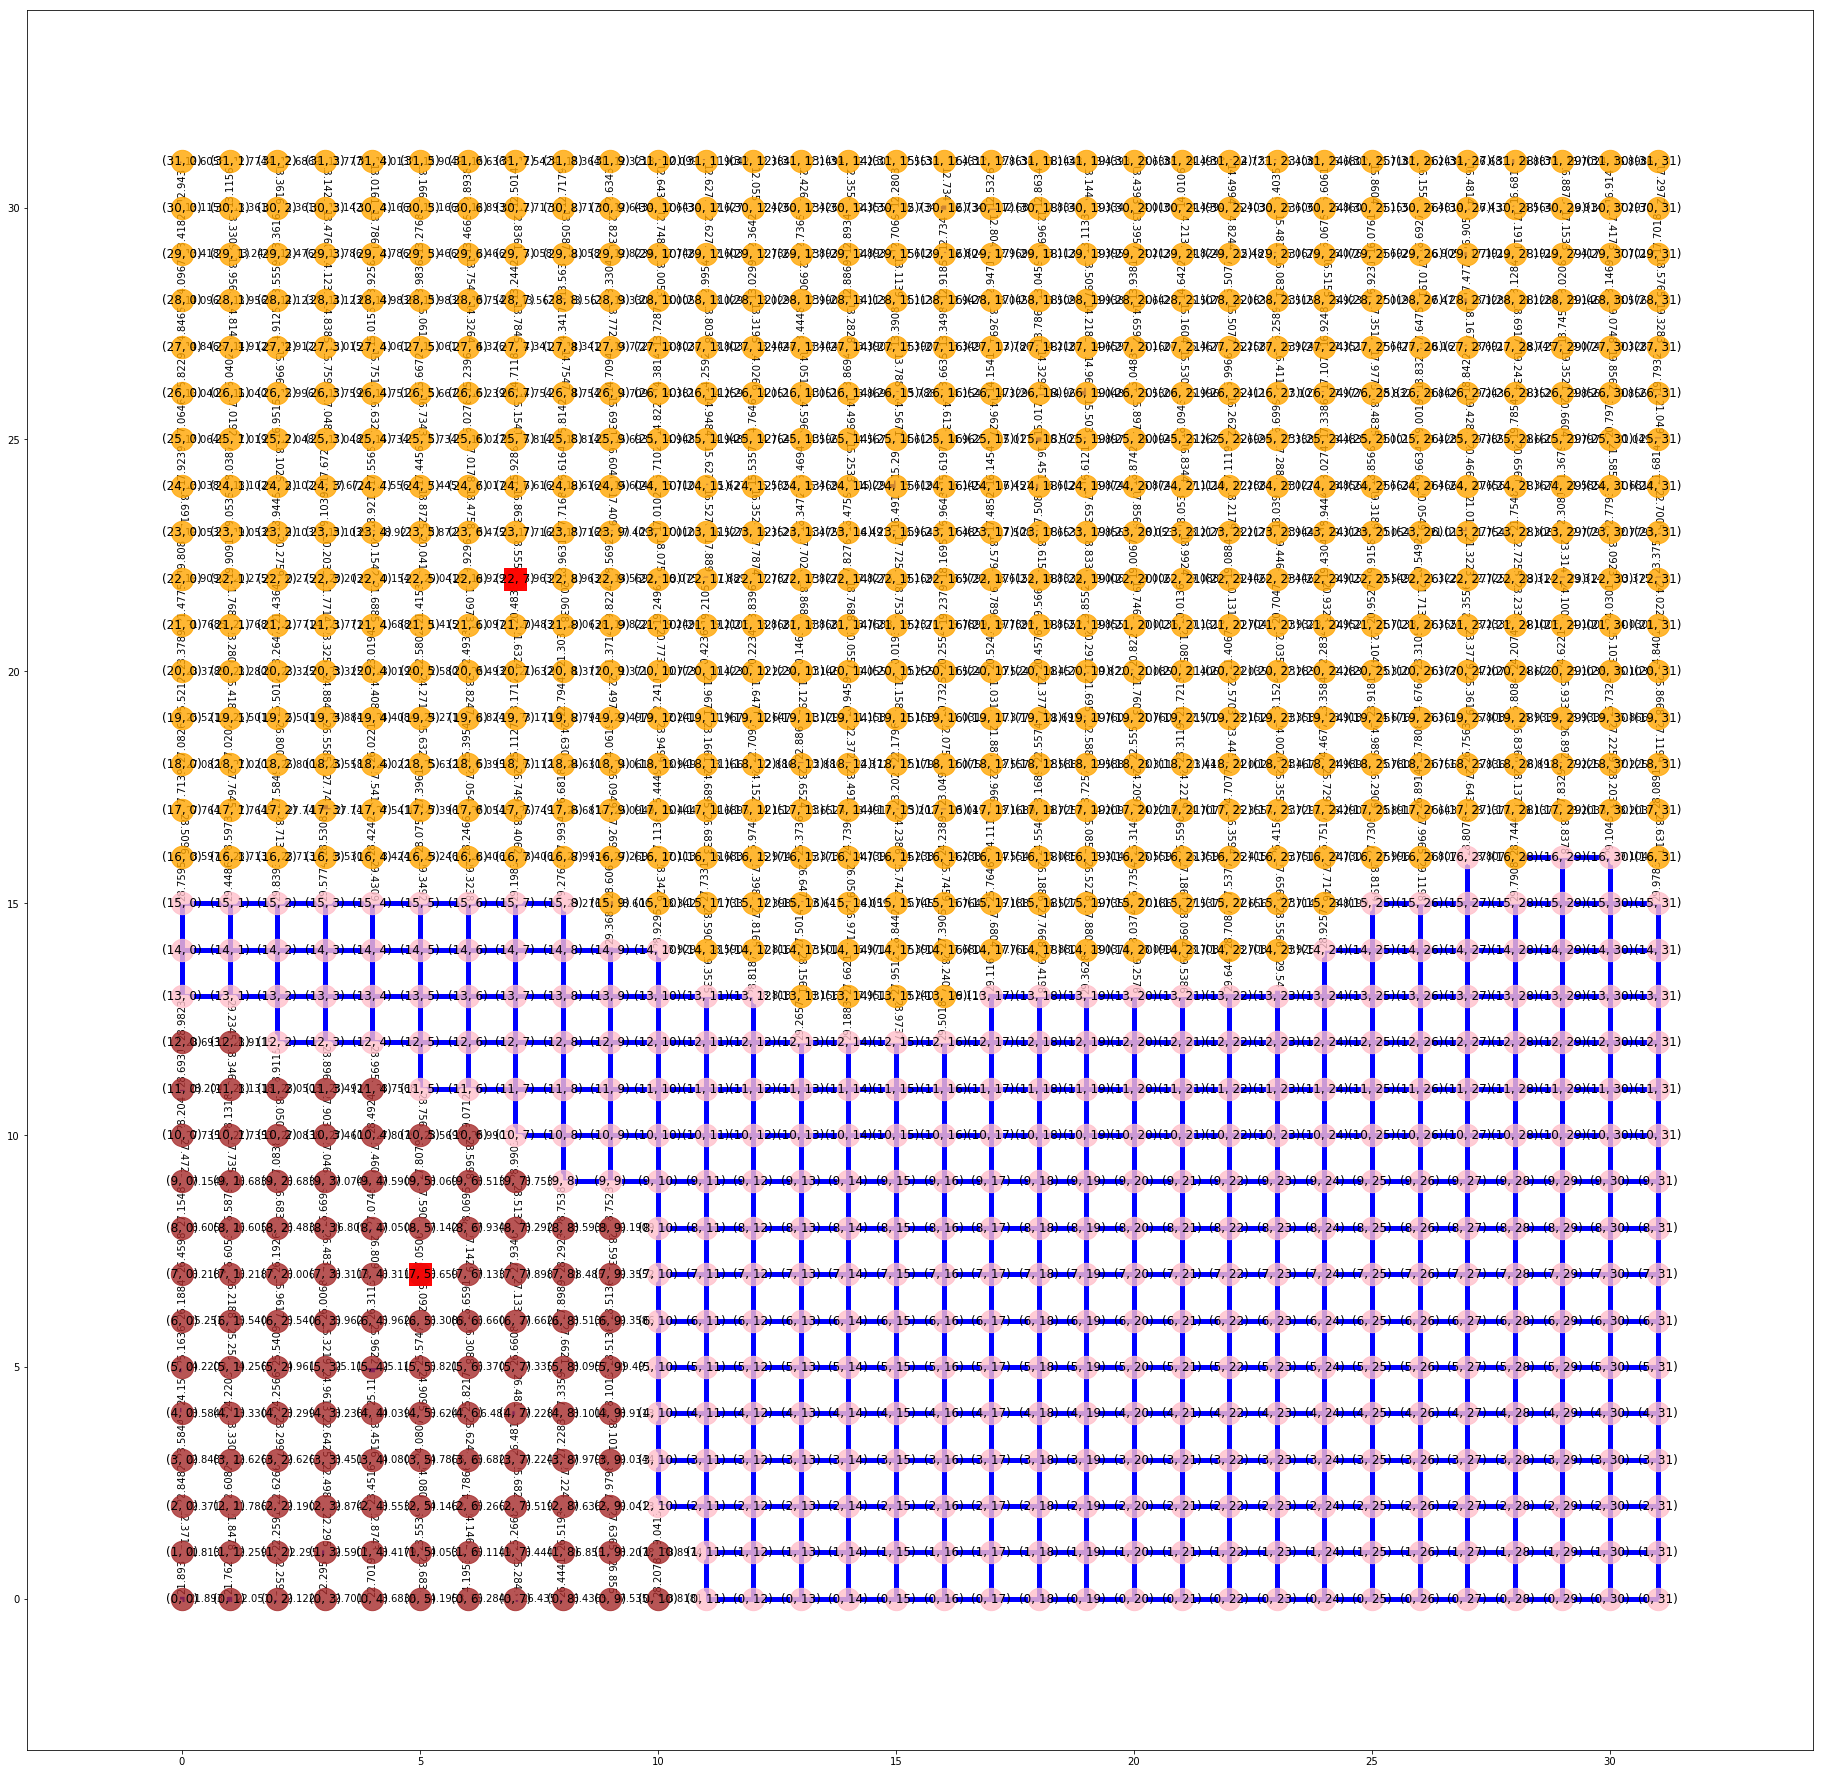

In [40]:
view_graph(w.image, w.image_graph)

In [42]:
w.image.shape

(32, 32)

In [44]:
w.image_graph.number_of_nodes()

1024

In [48]:
assignment_mask(w.image, w.image_graph)

array([[[ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        ..., 
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.]],

       [[ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        ..., 
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.]],

       [[ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        ..., 
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.]],

       ..., 
       [[ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        ..., 
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.]],

       [[ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        ..., 
        [ 126.,  129.,  127.],
        [ 126.,  129.,  127.],
        [ 

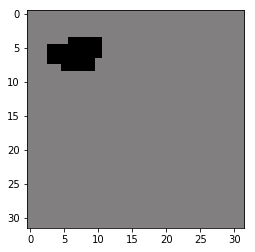

In [49]:
plt.imshow(assignment_mask(w.image, w.image_graph))

In [50]:
cv2.imwrite("mask.jpg", assignment_mask(w.image, w.ground_truth_graph))

True

In [115]:
test_altitude = np.expand_dims(w.image_graph.edge[(14, 3)][(15, 3)]['f_static_image'], axis=0)

In [116]:
test_weight = [[-12]]

In [117]:
with sess.as_default():
    print sess.run(f_static, feed_dict={image_placeholder: test_altitude,
                                        keras.backend.learning_phase(): 0})
    print sess.run(loss, feed_dict={image_placeholder: test_altitude,
                                    gradient_weights: test_weight,
                                    keras.backend.learning_phase(): 0})

[[-0.95060241]]
[[ 11.40722847]]


In [37]:
%matplotlib inline

In [91]:
image_tl = (15,10)
image_size = (100, 100)

In [92]:
test = cv2.imread('1G.jpg', 0)

In [93]:
test = test[image_tl[0]:image_tl[0] + image_size[0],
        image_tl[1]:image_tl[1] + image_size[1]]

In [94]:
seeds = list()

f = open("GT_Seeds.txt", 'r')
for line in f:
    x = int(float(re.split(' ', line)[0]))
    y = int(float(re.split(' ', line)[1]))
    seed = (x, y)
    seeds.append(seed)

In [ ]:
image_tl = (15,10)
image_size = (100, 100)
seeds = []
f = open("GT_Seeds.txt", 'r')
for line in f:
    x = int(float(re.split(' ', line)[0]))
    y = int(float(re.split(' ', line)[1]))
    seed = (x, y)
 # to read from GT_Seeds after crop generated seeds

    seeds.append(seed)

In [95]:
seeds

[(10, 18),
 (34, 6),
 (73, 3),
 (96, 3),
 (48, 16),
 (91, 20),
 (63, 32),
 (31, 38),
 (93, 47),
 (3, 46),
 (15, 65),
 (81, 70),
 (48, 80),
 (1, 89),
 (18, 95),
 (90, 97)]

In [96]:
for x, y in seeds:
    test[x][y] = 255

In [97]:
w.ground_truth_image.shape

(25, 25)

In [99]:
cv2.imshow(test, cmap="gray")

TypeError: Required argument 'mat' (pos 2) not found

In [38]:
view_graph(w.image, w.ground_truth_graph)

In [ ]:
            if ground_truth_path_distance <= shortest_path_distance:

                logging.info("\nEQUATION 10 WAS NOT SATISFIED!\n")
                logging.info("Ground truth Path Distance: %f", ground_truth_path_distance)
                logging.info("Shortest Path Distance: %f\n", shortest_path_distance)
                logging.info("\nGround truth path\n")
                logging.info(ground_truth_path)
                logging.info("\nShortest path\n")
                logging.info(shortest_path)


                #G = nx.subgraph(self.image_msf, shortest_path)
                #view_graph(self.image, G, figurename="Shortest_path.jpg")

                #G = nx.subgraph(self.constrained_msf, ground_truth_path)
                #view_graph(self.image, G, figurename="Ground_truth_path.jpg")

                root_missing_cut_edge = self._first_erroneous_cut_edge(shortest_path,
                                                                       self.ground_truth_cuts, 
                                                                       self.cut_edges)

                if assigned_seed != ground_truth_seed:
                    root_false_cut_edge = find_first_false_cut(ground_truth_path,
                                                               self.ground_truth_cuts,
                                                               self.cut_edges)
                else:
                    root_false_cut_edge = find_deviation(ground_truth_path, shortest_path)

                logging.info("Root error missing cut: ")
                logging.info(root_missing_cut_edge)

                # Check if the false cut is in cut edges list
                if (root_false_cut_edge in self.cut_edges or
                    tuple(reversed(root_false_cut_edge)) in self.cut_edges):
                    logging.info("Root error false cut: ")
                    logging.info(root_false_cut_edge)
                else:
                    logging.info("Root error: ")
                    logging.info(root_false_cut_edge)
                    root_false_cut_edge = ground_truth_distance_edge

                logging.info("Checking if T*(m*, w) = f_static(p*(w))")
                #print ground_truth_path_distance, "\t", self.image_graph.edge[root_false_cut_edge[0]]\
                #                                        [root_false_cut_edge[1]]['weight']
                logging.info(ground_truth_path_distance == 
                             self.image_graph.edge[root_false_cut_edge[0]]\
                             [root_false_cut_edge[1]]['weight'])

                # Apply edge error weights
                try:
                    edge_error_weights[root_missing_cut_edge]
                except KeyError:
                    edge_error_weights[root_missing_cut_edge] = 0
                finally:
                    edge_error_weights[root_missing_cut_edge] = \
                    edge_error_weights[root_missing_cut_edge] - 1

                try:
                    edge_error_weights[root_false_cut_edge]
                except KeyError:
                    edge_error_weights[root_false_cut_edge] = 0
                finally:
                    edge_error_weights[root_false_cut_edge] = \
                    edge_error_weights[root_false_cut_edge] + 1

In [51]:
# This placeholder will hold the root error edge values.
gradient_weights = tf.placeholder(tf.float32, shape=(1, None))

# Define optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001, )


loss = tf.reduce_sum(f_static)

# Compute gradients of predictions with respect to the parameters.
grads_and_vars = opt.compute_gradients(f_static, tf.trainable_variables())

capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in grads_and_vars]

# Apply gradients
update_step = opt.apply_gradients(capped_gvs)

sess = tf.Session() 
sess.run(tf.global_variables_initializer())

In [37]:
%matplotlib inline

In [147]:
images, weights = epoch_data(w.image_graph)

In [38]:
im = w.image_dict

Traceback (most recent call last):
  File "/home/collin/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/collin/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/collin/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/collin/anaconda2/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/collin/anaconda2/lib/python2.7/inspect.py", line 1012, in getframeinfo
    lines, lnum = findsource(frame)
  File "/home/collin/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 170, in findsource
    file = getsourcefile(object) or getfile(object)
  File 

IndexError: string index out of range

In [45]:
type()

<bound method Watershed.image_dict of <__main__.Watershed instance at 0x7f21ce345bd8>>

In [51]:
images[0,:,:,0]

array([[175, 169, 114, 169, 123, 150, 177, 213, 230, 224],
       [170, 150, 145, 189, 195, 200, 179, 173, 150, 197],
       [147,  90, 192, 154, 208, 166, 171, 196, 227, 227],
       [103, 160, 174, 188, 181, 138, 225, 203, 145, 130],
       [198, 146, 203, 207, 238, 180, 157, 175, 119, 148],
       [206, 217, 175, 204, 188, 181, 170, 156, 115, 152],
       [235, 192, 175, 184, 110, 116, 147, 179, 125, 140],
       [225, 237, 172, 169, 144, 168, 163, 155, 122, 161],
       [175, 140, 156, 123, 111, 104, 191, 135, 121, 116],
       [161, 132, 135, 147, 153,  90,  94, 127, 123, 106]], dtype=int16)

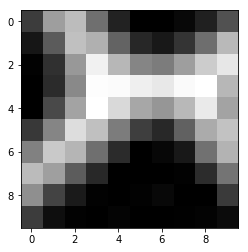

In [54]:
plt.imshow(images[0,:,:,1], cmap='gray')

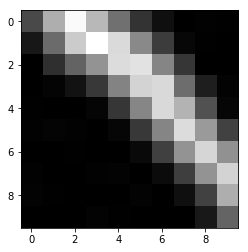

In [55]:
plt.imshow(images[1,:,:,1], cmap='gray')

In [37]:
with sess.as_default():
    preds = sess.run(f_static, feed_dict={image_placeholder: images,
                                          keras.backend.learning_phase(): 1})

NameError: name 'images' is not defined

In [38]:
preds

NameError: name 'preds' is not defined

In [64]:
plt.figure(figsize=(10,10))
plt.imsave("image", img, cmap='gray')

In [48]:
f_static

<tf.Tensor 'dense_6/Sigmoid:0' shape=(?, 1) dtype=float32>

In [49]:
gradient_weights

<tf.Tensor 'Placeholder_7:0' shape=(?, 1) dtype=float32>

In [44]:
view_graph(img, w.image_graph)

In [37]:
view_graph(img, w.image_msf, figurename="msf.jpg")

In [38]:
view_graph(img, w.constrained_msf, figurename="constrained_msf.jpg")

In [38]:
with sess.as_default():
    edge_vals = sess.run(f_static, feed_dict={image_placeholder: images,
                                              keras.backend.learning_phase(): 0})

In [39]:
edge_vals

array([[  8.06023680e+08],
       [  8.19974208e+08],
       [  8.15467776e+08],
       [  8.37393472e+08],
       [  8.45755904e+08],
       [  6.51255168e+08],
       [  8.27031744e+08],
       [  8.34356800e+08],
       [  8.25665344e+08],
       [  8.05620288e+08],
       [  8.41433792e+08],
       [  6.57619712e+08],
       [  8.12197056e+08],
       [  8.40009536e+08],
       [  5.47114496e+08],
       [  8.08230464e+08],
       [  8.24768064e+08],
       [  8.04055872e+08]], dtype=float32)

In [40]:
weights.shape

(18,)

In [40]:
view_graph(w.image, w.image_graph)

In [44]:
-1.04985118e-01 + (2.14060211e+00 * -0.001)

-0.10712572011

In [45]:
9.53887701e-02 + (5.23519516e-01 * -0.001)

0.094865250584

In [46]:
7.24785775e-02 + (-2.90366650e-01 * -0.001)

0.07276894415

In [38]:
with sess.as_default():
    sess.run(update_step, feed_dict={image_placeholder: images})

In [163]:
with sess.as_default():
    var = sess.run(tf.trainable_variables())
var[0]

array([[[[  4.51479107e-03,  -1.12456754e-02,   8.69725645e-03,
           -1.86721236e-03,  -1.10314444e-01,  -2.35224441e-02,
           -5.54655716e-02,  -2.92278007e-02,  -3.12924311e-02,
            3.44941318e-02,  -4.82114777e-02,   6.65174574e-02,
           -1.04361199e-01,   4.57509309e-02,  -2.10925192e-03,
           -7.03270957e-02],
         [ -3.72680500e-02,   8.56105089e-02,   5.69580495e-03,
           -7.14336708e-02,   2.54867971e-02,   2.59888768e-02,
           -1.02531210e-01,  -7.01071024e-02,  -1.07688010e-02,
           -9.28224921e-02,   6.40280992e-02,  -9.75799039e-02,
            2.17617750e-02,  -8.04330409e-03,   4.68908250e-02,
            6.64185137e-02]],

        [[  7.75953978e-02,  -1.11472279e-01,   4.30668294e-02,
            8.76056552e-02,   3.10087800e-02,  -4.43887115e-02,
            3.58899236e-02,  -1.09529115e-01,   7.70132691e-02,
           -3.94150242e-02,  -1.40464082e-02,   2.99396813e-02,
           -9.68156159e-02,   1.78606659e-02

In [46]:
with sess.as_default():
    g_and_v_after = sess.run(grads_and_vars, feed_dict={image_placeholder: images})

In [50]:
g_and_v_after[0][1]

array([[[[  2.54594952e-01,   1.26032501e-01,   4.75596935e-02,
            8.78683552e-02,   1.58827826e-02,   6.07168637e-02,
            1.30811155e-01,  -3.63997184e-03,  -1.58748731e-01,
            2.02438626e-02,   6.03471808e-02,  -9.36442986e-02,
           -9.09745023e-02,   7.62404054e-02,   1.58685744e-02,
            1.31612606e-02],
         [ -8.72233063e-02,   2.25537680e-02,  -2.30019819e-02,
            4.62761261e-02,   7.46647641e-02,   4.05647270e-02,
           -8.90969783e-02,  -5.68701364e-02,  -9.69274566e-02,
           -4.79533486e-02,   3.40013802e-02,  -3.82354893e-02,
            9.23930556e-02,  -2.72883456e-02,  -1.31714419e-02,
           -4.83951485e-03]],

        [[  1.98002964e-01,  -7.60322586e-02,   7.23815337e-02,
           -1.04166001e-01,   1.05324589e-01,  -2.60793287e-02,
            1.30634978e-01,   8.70610848e-02,  -1.39937550e-01,
            1.26010841e-02,  -8.66827369e-02,   4.04834598e-02,
            9.59796757e-02,  -3.82529646e-02

In [70]:
w.image_graph.node[(23, 17)]

{'assignment history': [(24, 17),
  (25, 17),
  (25, 18),
  (26, 18),
  (23, 18),
  (25, 19),
  (24, 19),
  (26, 17),
  (24, 18)],
 'seed': (23, 17),
 'type': 'seed',
 'value': 141}

In [116]:
edge_error_weights = dict()

nodes = list((n for n in w.image_msf if w.image_msf.node[n]['type']=='node'))
for node in nodes:

    m_hat = w.image_msf.node[node]['seed']
    m_star = w.constrained_msf.node[node]['seed']

    # Get the path from seed to node
    shortest_path = next(nx.all_simple_paths(w.image_msf, m_hat, node))
    ground_truth_path = next(nx.all_simple_paths(w.constrained_msf, m_star, node))
    

    
    if shortest_path != ground_truth_path:
        if m_hat == m_star:
            
            # If failure mode 1(the node was assigned to the wrong seed), then the root error edge of a
            # ground truth path is the first false cut edge in the ground truth path.  
            root_false_cut_edge = find_deviation(ground_truth_path, shortest_path)
        else:
            
            
            root_false_cut_edge = find_first_false_cut(ground_truth_path,
                                                       w.ground_truth_cuts,
                                                       w.cut_edges)
            
            print root_false_cut_edge
            
        try:
            edge_error_weights[root_false_cut_edge]
        except KeyError:
            edge_error_weights[root_false_cut_edge] = 0
        finally:
            edge_error_weights[root_false_cut_edge] = \
            edge_error_weights[root_false_cut_edge] - 1
print edge_error_weights

((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((10, 1), (10, 0))
((10, 1), (10, 0))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (

((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((10, 1), (10, 0))
((10, 1), (10, 0))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (7, 1))
((7, 0), (

In [71]:
images, weights = epoch_data(w.image_graph)

[  -5   -6  -29   -1  -17   -4 -324  675   -4   -1  -10    3 -244   30   -5
   -9  -11   -4  -29    3   -6   -1   -1]


In [72]:
with sess.as_default():
    f_s = sess.run(f_static, feed_dict={image_placeholder: images})
    print f_s

[[-0.86770433]
 [-0.86150527]
 [ 0.55998468]
 [-0.680305  ]
 [-0.72879285]
 [-0.55462462]
 [-0.30044127]
 [-0.96558088]
 [-0.89311039]
 [-0.53481734]
 [-0.84789008]
 [-0.05348736]
 [ 1.02194667]
 [-0.64810479]
 [-0.84875178]
 [-0.8317582 ]
 [-0.73306924]
 [-0.62017655]
 [-0.66460419]
 [-0.42611176]
 [-0.58739185]
 [-0.76089698]
 [-0.79264724]]


In [73]:
with sess.as_default():
    w = sess.run(root_edges, feed_dict={root_edges: [weights]})
    print w

[[  -5.   -6.  -29.   -1.  -17.   -4. -324.  675.   -4.   -1.  -10.    3.
  -244.   30.   -5.   -9.  -11.   -4.  -29.    3.   -6.   -1.   -1.]]


In [228]:
f_s.shape

(18, 1)

In [229]:
w.shape

(1, 18)

In [230]:
np.dot(w, f_s)

array([[-145.38752747]], dtype=float32)

In [207]:
print len(weights), len(f_s)

18 18


In [231]:
with sess.as_default():
    mul = sess.run(mult_op, feed_dict={image_placeholder: images, root_edges: [weights]})
    print mul

[[-145.38754272]]


In [167]:
with sess.as_default():
    l = sess.run(loss, feed_dict={image_placeholder: images, root_edges: weights})
    print l

272.979


In [39]:
test_list = [int(random.randint(-1,1)) for i in xrange(w.image_graph.number_of_edges())]
test_list = np.array(test_list)

array([-1,  0,  1])

In [42]:
batches = create_list_batches(test_list, batch_size=32)

In [45]:
batches[0].shape

(32,)

In [272]:
boundary_nodes = list()

for u, v in w.image_graph.edges_iter():
    if w.image_msf.node[u]['seed'] is not w.image_msf.node[v]['seed']:
        boundary_nodes.extend((u,v))
        
boundary_nodes = list(set(boundary_nodes))
G = nx.subgraph(w.image_graph, boundary_nodes)
view_graph(img, G)

In [273]:
boundary_nodes

[(28, 18),
 (25, 16),
 (24, 17),
 (27, 17),
 (26, 16),
 (30, 18),
 (29, 18),
 (24, 18),
 (31, 18),
 (23, 17),
 (27, 16),
 (26, 17),
 (29, 17),
 (23, 16),
 (28, 16),
 (25, 18),
 (22, 17),
 (31, 17),
 (30, 16),
 (29, 16),
 (26, 18),
 (28, 17),
 (25, 17),
 (27, 18),
 (24, 16),
 (31, 16),
 (30, 17),
 (23, 18)]

In [254]:

[boundary_nodes.extend((w.image_msf.node,)) if self.image_msf.node[e[0]]['seed']\
        is not self.image_msf.node[e[1]]['seed'] else '' for e in\
        self.image_graph.edges_iter()]

[((22, 19), (23, 19)),
 ((23, 19), (24, 19)),
 ((22, 17), (23, 17)),
 ((23, 20), (22, 20)),
 ((23, 20), (23, 21)),
 ((23, 20), (24, 20)),
 ((24, 16), (24, 17)),
 ((24, 18), (25, 18)),
 ((24, 18), (24, 19)),
 ((22, 18), (23, 18)),
 ((23, 16), (23, 17)),
 ((25, 17), (24, 17))]

In [256]:
nodes = []
for edge in w.cut_edges:
    nodes.append(edge[0])

In [257]:
G = nx.subgraph(w.image_graph, nodes)
view_graph(img, G)

In [115]:
view_graph(img, w.image_msf, figurename="image_msf.jpg")

In [116]:
view_graph(img, w.constrained_msf, figurename="constrained_msf.jpg")

In [114]:
view_graph(img, w.image_graph, figurename="image_graph.jpg")

In [122]:
def first_erroneous_cut_edge(shortest_path, ground_truth_cuts, cut_edges):
    """
    Computes the root error missing cut of a shortest path.

    Every incorrect shortest path has at least one erroneous cut edge.  The first such
    edge shall be called the path's root error edge p(w) and is always a missing cut.

    Args:
        shortest_path (list): The list of edges in the shortest path.
        ground_truth_path (list): The list of edges in the ground truth path.

    Returns:
        tuple: The first erroneous cut edge in the shortest path.
    """
    
    print shortest_path
    
    for i, node in enumerate(shortest_path):
        try:
            edge = (shortest_path[i], shortest_path[i + 1])
            if edge in ground_truth_cuts or tuple(reversed(edge)) in ground_truth_cuts:
                if edge not in cut_edges and tuple(reversed(edge)) not in cut_edges:
                    print edge, " was a cut edge"
                    return edge

        except IndexError:
            print "Something went wrong."
            continue

In [123]:
nodes = list((n for n in w.image_graph if w.image_graph.node[n]['type']=='node'))

for node in nodes:
    
    m_hat = w.image_msf.node[node]['seed']
    m_star = w.constrained_msf.node[node]['seed']
    
    #Get the path from seed to node
    phi_hat = next(nx.all_simple_paths(w.image_msf, m_hat, node))
    phi_star = next(nx.all_simple_paths(w.constrained_msf, m_star, node))
    
    if phi_hat != phi_star:
        test_shortest_path = phi_hat
        test_ground_truth_path = phi_star
        break    
first_erroneous_cut_edge(phi_hat, w.ground_truth_cuts, w.cut_edges)

[(23, 17), (24, 17), (24, 18), (25, 18), (26, 18), (26, 17), (27, 17), (27, 16), (28, 16), (28, 15), (28, 14), (29, 14), (30, 14), (30, 13), (30, 12), (30, 11), (30, 10), (29, 10), (29, 9), (29, 8), (30, 8), (31, 8), (31, 7), (31, 6)] 

[(8, 1), (9, 1), (9, 2), (10, 2), (11, 2), (11, 3), (11, 4), (10, 4), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (15, 5), (15, 4), (15, 3), (15, 2), (15, 1), (16, 1), (17, 1), (18, 1), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (24, 1), (24, 2), (25, 2), (26, 2), (26, 3), (26, 4), (25, 4), (25, 5), (25, 6), (25, 7), (26, 7), (27, 7), (27, 8), (27, 9), (28, 9), (29, 9), (29, 8), (30, 8), (31, 8), (31, 7), (31, 6)]
((8, 1), (9, 1))  was a cut edge


((8, 1), (9, 1))

In [201]:
weights[edge] = 5

In [202]:
weights[edge]

5

In [204]:
for k, v in weights.iteritems():
    print k, v

((0, 0), (0, 1)) 5


In [207]:


for edge in img_graph.edges_iter():
    try:
        print weights[edge]
    except KeyError:
        #print 0
        continue

5


In [209]:
for edge in img_graph.edges_iter():
    weights[edge] = np.random.randint(-10, high=10)

In [211]:
nx.set_edge_attributes(img_graph, 'error_weights', weights)

In [29]:
for i, edge in enumerate(w.image_graph.edges_iter()):
    if edge[0][0] == 6:
        print edge

((6, 14), (5, 14))
((6, 14), (7, 14))
((6, 14), (6, 15))
((6, 14), (6, 13))
((6, 1), (6, 2))
((6, 1), (6, 0))
((6, 1), (7, 1))
((6, 18), (6, 19))
((6, 18), (6, 17))
((6, 18), (5, 18))
((6, 18), (7, 18))
((6, 12), (6, 11))
((6, 12), (7, 12))
((6, 12), (5, 12))
((6, 12), (6, 13))
((6, 7), (5, 7))
((6, 7), (6, 6))
((6, 7), (7, 7))
((6, 7), (6, 8))
((6, 16), (6, 15))
((6, 16), (6, 17))
((6, 16), (5, 16))
((6, 11), (7, 11))
((6, 11), (5, 11))
((6, 11), (6, 10))
((6, 2), (6, 3))
((6, 2), (5, 2))
((6, 2), (7, 2))
((6, 5), (6, 4))
((6, 5), (7, 5))
((6, 5), (5, 5))
((6, 5), (6, 6))
((6, 9), (5, 9))
((6, 9), (6, 10))
((6, 9), (6, 8))
((6, 0), (5, 0))
((6, 19), (7, 19))
((6, 10), (7, 10))
((6, 13), (7, 13))
((6, 4), (6, 3))


In [55]:
view_graph(img, w.image_msf)

In [57]:
img_graph = w.image_graph
img_msf = w.image_msf
constrained_msf = w.constrained_msf

In [88]:
def get_test_data():    
    return np.random.rand(5, 15, 15, 2), np.random.randint(-5, high=5, size=(5,1))

In [89]:
test_images, test_weights = get_test_data()

In [98]:
for edge in img_msf.edges_iter():
    img_msf.edge[edge[0]][edge[1]]['children'] = np.random.randint(-10, high=10)

In [119]:
np.array(images)

(1984, 15, 15, 2)

In [142]:
images, weights = epoch_data(w.image_graph)

image_batches = create_batches(images, 32)
weight_batches = create_batches(weights, 32)

# Reduce amount of data because my computer sucks :(
images = images[0:32, :, :, :]
weights = weights[0:32]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_step, feed_dict={image_placeholder: images,
                                   root_edges: weights})

In [151]:
create_batches(images, 32)

[array([[[[  9.80000000e+01,   3.64792847e-01],
          [  7.10000000e+01,   7.25091301e-01],
          [  1.32000000e+02,   4.05334365e-01],
          ..., 
          [  9.30000000e+01,   6.28281372e-01],
          [  7.60000000e+01,   6.11711457e-01],
          [  6.40000000e+01,   4.14662189e-01]],
 
         [[  9.50000000e+01,   3.77325793e-01],
          [  1.02000000e+02,   1.73868004e-01],
          [  1.23000000e+02,   7.69467802e-02],
          ..., 
          [  7.80000000e+01,   6.91988722e-02],
          [  7.20000000e+01,   3.46844368e-01],
          [  1.12000000e+02,   7.25885727e-01]],
 
         [[  9.80000000e+01,   5.29993044e-01],
          [  7.10000000e+01,   3.69634304e-01],
          [  1.32000000e+02,   1.26574017e-01],
          ..., 
          [  9.30000000e+01,   5.35719450e-01],
          [  7.60000000e+01,   8.41889793e-02],
          [  6.40000000e+01,   4.65079710e-01]],
 
         ..., 
         [[  1.27000000e+02,   3.92164644e-01],
          [  1.0

In [144]:
            # Get path distance
            t, t_edge = max_arc_topographical(self.image_msf, phi_hat)
            t_star, t_star_edge = max_arc_topographical(self.constrained_msf, phi_star)    

            # The approach I take here is if the node is assigned to the correct seed,
            # then nothing happens.  However, if the node is assigned to the incorrect seed,
            # then two things happen.  First, the image that was used to predict the edge weight is 
            # identified.  This is because when an edge is calculated, it can be calculated from node A
            # to node B, or node B to node A.  Secondly, the image is then added a dictionary  where the 
            # keys are the edges and the values are the images used to calculate the edge.
            
            print self.image_graph.edge[t_edge[0]][t_edge[1]]
        
            if phi_hat == phi_star:
                    continue
            else: 

                # If the node is incorrectly assigned, then 

In [145]:
print images.shape, weights.shape

(32, 15, 15, 2) (32,)


In [62]:
# Where would be the best place to store the children of the root edge.
# I would say that it is best to store that in the netowrkx edge.


def weight_function(MSF, CMSF, node):
    """
    I would like to provide an MSF, CMSF, and a node and get back the row and the row star.
    
    Parameters
    ===========
    MSF: graph
        The minimum spanning forest.
    CMSF: graph
        The Constrained minimum spanning forest.
    node: tuple
        The node to be evaluated.
    """
    
    m_hat = MSF.node[node]['seed']
    m_star = CMSF.node[node]['seed']
    
    #Get the path from seed to node
    phi_hat = next(nx.all_simple_paths(MSF, m_hat, node))
    phi_star = next(nx.all_simple_paths(CMSF, m_star, node))

    #Get path distance
    t = max_arc_topographical_distance(phi_hat, img_msf)
    t_star = max_arc_topographical_distance(phi_star, CMSF)
    
    row = p(MSF, CMSF, node)
    
    row_star = p_star(MSF, CMSF, node)
    
    
    return row, row_star
    

In [58]:
nodes = list((n for n in img_graph if img_graph.node[n]['type']=='node'))
mode_1 = []
mode_2 = []
V_ = []
correct_nodes = []

# {Node, shortest path, ground truth path}
incorrect_paths = {}


c = itertools.count(0)
for node in nodes:
    
    m_hat = img_msf.node[node]['seed']
    m_star = constrained_msf.node[node]['seed']
    
    #Get the path from seed to node
    phi_hat = next(nx.all_simple_paths(img_msf, m_hat, node))
    phi_star = next(nx.all_simple_paths(constrained_msf, m_star, node))

    #Get path distance
    t = max_arc_topographical_distance(phi_hat, img_msf)
    t_star = max_arc_topographical_distance(phi_star, constrained_msf)
    
    print "Node: {} Assigned Seed: {} Path Distance: {}".format(node, m_hat, t)

    if phi_hat == phi_star:
        correct_nodes.append(node)
    else: 
        V_.append(node)
        if m_hat != m_star:
            mode_1.append(node)
            incorrect_paths[node] = [phi_hat, phi_star]
        elif phi_hat != phi_star:
            mode_2.append(node)
            incorrect_paths[node] = [phi_hat, phi_star]
    
    
print len(V_), len(mode_1) + len(mode_2), len(correct_nodes)

Node: (7, 3) Assigned Seed: (8, 1) Path Distance: 0.349301457405
Node: (31, 6) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (5, 31) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (20, 25) Assigned Seed: (23, 17) Path Distance: 0.489943534136
Node: (16, 9) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (6, 28) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (21, 28) Assigned Seed: (23, 17) Path Distance: 0.351304620504
Node: (19, 4) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (17, 20) Assigned Seed: (23, 17) Path Distance: 0.65680372715
Node: (7, 25) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (22, 19) Assigned Seed: (23, 17) Path Distance: 0.521331250668
Node: (20, 7) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (18, 19) Assigned Seed: (23, 17) Path Distance: 0.319327414036
Node: (23, 26) Assigned Seed: (23, 17) Path Distance: 0.485396951437
Node: (21, 6) Assigned Seed: (23, 17) Path Dis

Node: (1, 18) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (25, 13) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (15, 6) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (13, 18) Assigned Seed: (23, 17) Path Distance: 0.554794669151
Node: (2, 25) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (26, 10) Assigned Seed: (23, 17) Path Distance: 0.411369264126
Node: (0, 9) Assigned Seed: (23, 17) Path Distance: 0.307727456093
Node: (3, 4) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (27, 3) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (30, 12) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (4, 7) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (28, 4) Assigned Seed: (23, 17) Path Distance: 0.5775796175
Node: (31, 9) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (5, 6) Assigned Seed: (23, 17) Path Distance: 0.423300743103
Node: (29, 9) Assigned Seed: (23, 17) Path Distanc

Node: (3, 1) Assigned Seed: (23, 17) Path Distance: 0.290696322918
Node: (27, 12) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (30, 11) Assigned Seed: (23, 17) Path Distance: 0.557936906815
Node: (4, 26) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (28, 15) Assigned Seed: (23, 17) Path Distance: 0.327653706074
Node: (31, 2) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (5, 27) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (29, 14) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (16, 13) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (6, 16) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (21, 24) Assigned Seed: (23, 17) Path Distance: 0.532326340675
Node: (19, 8) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (17, 8) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (7, 21) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (22, 23) Assigned Seed: (23, 17) Path

Node: (18, 13) Assigned Seed: (23, 17) Path Distance: 0.537194609642
Node: (23, 16) Assigned Seed: (23, 17) Path Distance: 0.287172853947
Node: (21, 0) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (8, 11) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (22, 15) Assigned Seed: (23, 17) Path Distance: 0.378015100956
Node: (9, 10) Assigned Seed: (23, 17) Path Distance: 0.674091696739
Node: (23, 14) Assigned Seed: (23, 17) Path Distance: 0.303519785404
Node: (10, 1) Assigned Seed: (8, 1) Path Distance: 0.0492432117462
Node: (8, 17) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (11, 12) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (0, 23) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (24, 20) Assigned Seed: (23, 17) Path Distance: 0.522721588612
Node: (14, 11) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (12, 15) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (1, 22) Assigned Seed: (23, 17) Pat

Node: (15, 7) Assigned Seed: (23, 17) Path Distance: 0.319151580334
Node: (13, 19) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (2, 24) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (26, 13) Assigned Seed: (23, 17) Path Distance: 0.426481425762
Node: (0, 8) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (29, 16) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (3, 5) Assigned Seed: (23, 17) Path Distance: 0.360222160816
Node: (27, 0) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (30, 15) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (4, 6) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (28, 11) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (31, 14) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (5, 7) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (29, 10) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (16, 1) Assigned Seed: (23, 17) Path Di

Node: (31, 3) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (5, 28) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (29, 15) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (16, 12) Assigned Seed: (23, 17) Path Distance: 0.375975400209
Node: (6, 19) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (21, 25) Assigned Seed: (23, 17) Path Distance: 0.351304620504
Node: (19, 9) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (17, 9) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (7, 26) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (22, 22) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (20, 2) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (18, 14) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (23, 23) Assigned Seed: (23, 17) Path Distance: 0.293238759041
Node: (21, 3) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (8, 8) Assigned Seed: (23, 17) Path 

Node: (21, 30) Assigned Seed: (23, 17) Path Distance: 0.481672495604
Node: (19, 2) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (17, 22) Assigned Seed: (23, 17) Path Distance: 0.509629189968
Node: (7, 31) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (22, 29) Assigned Seed: (23, 17) Path Distance: 0.3804949224
Node: (20, 5) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (18, 21) Assigned Seed: (23, 17) Path Distance: 0.591242730618
Node: (23, 24) Assigned Seed: (23, 17) Path Distance: 0.306140780449
Node: (8, 3) Assigned Seed: (8, 1) Path Distance: 0.445292085409
Node: (9, 2) Assigned Seed: (8, 1) Path Distance: 0.718392968178
Node: (14, 25) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (10, 25) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (15, 28) Assigned Seed: (23, 17) Path Distance: 0.418789893389
Node: (11, 20) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (0, 31) Assigned Seed: (23, 17) Path Dist

Node: (26, 27) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (0, 26) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (24, 7) Assigned Seed: (23, 17) Path Distance: 0.30269163847
Node: (12, 26) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (27, 18) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (1, 27) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (25, 6) Assigned Seed: (23, 17) Path Distance: 0.448887377977
Node: (13, 27) Assigned Seed: (23, 17) Path Distance: 0.545365810394
Node: (28, 21) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (2, 0) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (26, 5) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (29, 24) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (3, 29) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (27, 8) Assigned Seed: (23, 17) Path Distance: 0.289486408234
Node: (30, 7) Assigned Seed: (23, 17) Path D

In [48]:
mode_1

[]

In [60]:
p = []
p_star1 = []
p_star2 = []
c = itertools.count(0)
for node in incorrect_paths:
    print "Node: ", node, ""
    shortest_path = incorrect_paths[node][0]
    ground_truth_path = incorrect_paths[node][1]
    
    m_hat = img_msf.node[node]['seed']
    m_star = constrained_msf.node[node]['seed']
    
    #Get the path from node to seed
    phi_hat = next(nx.all_simple_paths(img_msf, node, m_hat))
    phi_star = next(nx.all_simple_paths(constrained_msf, node, m_star))
    
    #Calculate Row
    for x in range(len(phi_hat) - 1):
        edge = (phi_hat[x], phi_hat[x + 1])
        if edge in hummus_star:
            if edge not in hummus:
                print "Missing Cut: {}".format(edge)
                p.append(edge)
                break
                #G = img_msf.subgraph(incorrect_paths[node][0])
                #G2 = constrained_msf.subgraph(incorrect_paths[node][1])
                #view_graph(img, G, figurename='paths/a_{}.jpg'.format(next(c)))
                #view_graph(img, G2, figurename='paths/aa_{}.jpg'.format(next(c)))
                
    
    for x in range(len(phi_star) - 1):
        edge = (phi_star[x], phi_star[x + 1])
        if edge in hummus:
            if edge not in hummus_star:
                p_star1.append(edge)
                print "False Cut: {}".format(edge)
                break
                
    for x in range(len(phi_star) - 1):
        phi_star_edge = (phi_star[x], phi_star[x + 1])
        phi_hat_edge = (phi_hat[x], phi_hat[x + 1])
        if phi_star_edge != phi_hat_edge:
            p_star2.append(edge)
            #print phi_star_edge, "\t", phi_hat_edge
            print "False Cut: ", edge, "\n"
            break
p_star = p_star1 + p_star2

Node:  (31, 6) 


NameError: name 'hummus_star' is not defined

In [ ]:
T_star = []
        self.T = field_of_view(self.augmented_image, (0,0), window_size)
        self.T = np.expand_dims(self.T, axis=0)

        loss = 0

        nodes = list((n for n in self.image_msf if self.image_msf.node[n]['type']=='node'))
        
        for node in nodes:
            
            # Get assigned seeds for MSF and constrained MSF.
            m_hat = self.image_msf.node[node]['seed']
            m_star = self.constrained_msf.node[node]['seed']

            # Get the path from seed to node
            phi_hat = next(nx.all_simple_paths(self.image_msf, m_hat, node))
            phi_star = next(nx.all_simple_paths(self.constrained_msf, m_star, node))

            # Get path distance
            t, t_edge = max_arc_topographical(self.image_msf, phi_hat)
            t_star, t_star_edge = max_arc_topographical(self.constrained_msf, phi_star)    

            if phi_hat == phi_star:
                    continue
            else: 

                # Predict the node
                print t_edge
                node = t_edge[0]
                fov = self.input_images[node]
                x = np.expand_dims(fov, axis=0)
                with sess.as_default():
                    weight = sess.run([f_static], feed_dict={image_placeholder: x})[0][0][0]

                if t != weight:
                    node = t_edge[1]
                    fov = self.input_images[node]
                    x = np.expand_dims(fov, axis=0)
                    with sess.as_default():
                        weight = sess.run([f_static], feed_dict={image_placeholder: x})[0][0][0]
                    if t != weight:
                        print "Error"

                print "{} - {} = {}".format(t_star, t, (t_star - t))
                print "{} - {} = {}".format(t_star, weight, (t_star - weight))

                self.T_star.append(t_star)
                T1 = field_of_view(self.augmented_image, node, self.window_size)
                T1 = np.expand_dims(T1, axis=0)

                self.T = np.concatenate((T, T1),axis=0)
                
                loss = loss + (t_star - t)

        self.T = np.delete(T, 0, 0)

In [77]:
# Set image size
window_tl = (50,30)
window_size = (32, 32)
fov_size = (32, 32)

#import Images
img = cv2.imread('1O.jpg', 0)
gt = cv2.imread('1G.jpg', 0)

#resize
img = img[window_tl[0]:window_tl[0] + window_size[0],
          window_tl[1]:window_tl[1] + window_size[1]]
gt = gt[window_tl[0]:window_tl[0] + window_size[0],
        window_tl[1]:window_tl[1] + window_size[1]]

#set type
img = img.astype(np.int16)
gt = gt.astype(np.int16)

#Pad image for field of view
I = np.pad(img,(fov_size[0],fov_size[1]),'reflect')

boundary_probabilities = get_boundary_probabilities(I)

#Augment the image with boundary probabilities
I_a = np.dstack((I, boundary_probabilities))

In [78]:
# Get input images
input_images = dict()

for x in range(window_size[0]):
    for y in range(window_size[1]):
        node = (x, y)
        input_images[node] = field_of_view(I_a, node, fov_size)

In [89]:
I_a.shape

(96, 96, 2)

In [87]:
for k, v in input_images.iteritems():
    print v.shape

(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32, 32, 2)
(32,

In [108]:
#Translate image to 4 connected grid graph
img_graph = img_to_graph(img)
img_graph.name = "image_graph"
ground_truth_graph = img_to_graph(gt)
ground_truth_graph.name = "ground_truth_graph"

In [250]:
#import seeds
seeds = []
f = open("seeds1G.txt", 'r')
for line in f:
    x = int(float(re.split(' ', line)[0]))
    y = int(float(re.split(' ', line)[1]))
    seed = (x, y)
    
    if x >= window_tl[0] and x <= window_tl[0] + window_size[0]:
        if y >= window_tl[1] and y <= window_tl[1] + window_size[1]:
            x = x - window_tl[0]
            y = y - window_tl[1]
            seed = (x, y)
            seeds.append(seed)

In [251]:
#plant seeds
img_graph = plant_seeds(img_graph, seeds)
ground_truth_graph = plant_seeds(ground_truth_graph, seeds)

In [157]:
feed = [int(random.randint(-1,1)) for i in xrange(num_of_edges)]

In [159]:
with tf.Session() as sess:
    
    sh = sess.run(R_e, feed_dict={R_e: feed})
print sh

[ 1  0 -1 ...,  1 -1 -1]


In [136]:
R_e

<tf.Tensor 'Placeholder_14:0' shape=(1984, 1) dtype=int8>

In [39]:
fov = input_images[(0,0)]
x = np.expand_dims(fov, axis=0)
x.shape

(1, 32, 32, 2)

In [129]:
import keras
import tensorflow as tf

# Dummy input
test = np.random.rand(1, 32, 32, 1)

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 1))

# Define model
l1 = keras.layers.Conv2D(16, 5, padding = 'same', activation='elu') (x)
l2 = keras.layers.Flatten()(l1)
l3 = keras.layers.Dense(128, activation='relu') (l2)
predictions = keras.layers.Dense(1) (l3)

grads = tf.gradients(predictions, [l1, l2, l3])

apply_l1_grads = tf.add(l1, grads[0])
apply_l2_grads = tf.add(l2, grads[1])
apply_l3_grads = tf.add(l3, grads[2])

# Define optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)

with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    y = sess.run(predictions, feed_dict={x: test})
    
    # Get gradients of y w.r.t model parameters.
    #gradients = sess.run(tf.gradients(y, model_parameters))

In [130]:
y

array([[-0.02749706]], dtype=float32)

In [131]:
iterations = 200

In [132]:
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for i in xrange(iterations):
        sess.run([apply_l1_grads, apply_l2_grads, apply_l3_grads], feed_dict={x: test})
        y = sess.run(predictions, feed_dict={x: test})
        print y

[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.02710382]]
[[-0.027

In [133]:
y

array([[-0.02710382]], dtype=float32)

In [71]:
with tf.Session() as sess:
     a = sess.run(tf.gradients(preds, l1))
print a

TypeError: Fetch argument None has invalid type <type 'NoneType'>

In [40]:
with sess.as_default():
    weight = sess.run([preds], feed_dict={image_placeholder: x})[0][0][0]

In [41]:
weight

-0.044026881

In [109]:
#Get MSF
print "Calculating Image MSF"
img_msf = prims_on_demand(img_graph)
img_msf.name = "Image_MSF"
print "Gt MSF"
gt_msf = prims_msf(ground_truth_graph)
gt_msf.name = "GT_MSF"

#Create lists of cut edges
hummus_star = []
trash = [hummus_star.append(e) if gt_msf.node[e[0]]['seed'] is not gt_msf.node[e[1]]['seed'] else '' for e in ground_truth_graph.edges_iter()]

hummus = []
trash = [hummus.append(e) if img_msf.node[e[0]]['seed'] is not img_msf.node[e[1]]['seed'] else '' for e in img_graph.edges_iter()]

#Remove cut edges from graph
gt_cuts = gt_msf.copy()
gt_cuts.remove_edges_from(hummus)

img_cuts = img_graph.copy()
img_cuts.remove_edges_from(hummus_star)

print "Calculating Constrained MSF"
constrained_msf = prims_on_demand(img_cuts)
constrained_msf.name = "constrained_MSF"

Calculating Image MSF


TypeError: prims_on_demand() takes exactly 2 arguments (1 given)

In [33]:
view_graph(img, img_msf, figurename='img_msf.jpg')

1
2


In [ ]:
T_star = []
T = field_of_view(I_a, (0,0), fov_size)
T = np.expand_dims(T, axis=0)

msf = img_msf
cons_msf = constrained_msf

loss = 0
i = 0
a = []

nodes = list((n for n in msf if msf.node[n]['type']=='node'))
for node in nodes:

    m_hat = msf.node[node]['seed']
    m_star = cons_msf.node[node]['seed']

    # Get the path from seed to node
    phi_hat = next(nx.all_simple_paths(msf, m_hat, node))
    phi_star = next(nx.all_simple_paths(cons_msf, m_star, node))

    # Get path distance
    t, t_edge = max_arc_topographical(msf, phi_hat)
    t_star, t_star_edge = max_arc_topographical(cons_msf, phi_star)    
    
    if phi_hat == phi_star:
            continue
    else: 
        
        # Predict the node
        print t_edge
        node = t_edge[0]
        fov = input_images[node]
        x = np.expand_dims(fov, axis=0)
        with sess.as_default():
            weight = sess.run([preds], feed_dict={image_placeholder: x})[0][0][0]
        
        if t != weight:
            node = t_edge[1]
            fov = input_images[node]
            x = np.expand_dims(fov, axis=0)
            with sess.as_default():
                weight = sess.run([preds], feed_dict={image_placeholder: x})[0][0][0]
            if t != weight:
                print "OH SHIT IT'S AN ALIEN!!"
                
        print "{} - {} = {}".format(t_star, t, (t_star - t))
        print "{} - {} = {}".format(t_star, weight, (t_star - weight))
        
        T_star.append(t_star)
        T1 = field_of_view(I_a, node, fov_size)
        T1 = np.expand_dims(T1, axis=0)
        
        T = np.concatenate((T, T1),axis=0)
        
        i = i + 1
        loss = loss + (t_star - t)
        #f_p = img_graph.edge[t_star_edge[0]][t_star_edge[1]]['weight']
        #print t_star, f_p
        #if t_star != f_p:
        #    print "problem"
        #else:
        #    print "no problem"
            
    
    
T = np.delete(T, 0, 0)
print loss

In [ ]:
len(batches)

In [43]:
# Define cost
cost = tf.reduce_sum(preds)

# Define optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.00001).minimize(cost)

with sess.as_default():
    sess.run(tf.global_variables_initializer())
    for x in batches:
        opt.run(feed_dict={image_placeholder: x})
        best = sess.run([preds], feed_dict={image_placeholder: x})

NameError: name 'batches' is not defined

In [ ]:
best

In [ ]:
#Get MSF
print "Image MSF"
img_msf = prims_on_demand(img_graph)
img_msf.name = "Image_MSF"
print "Gt MSF"
gt_msf = prims_msf(ground_truth_graph)
gt_msf.name = "GT_MSF"

#Create lists of cut edges
hummus_star = []
trash = [hummus_star.append(e) if gt_msf.node[e[0]]['seed'] is not gt_msf.node[e[1]]['seed'] else '' for e in ground_truth_graph.edges_iter()]

hummus = []
trash = [hummus.append(e) if img_msf.node[e[0]]['seed'] is not img_msf.node[e[1]]['seed'] else '' for e in img_graph.edges_iter()]

#Remove cut edges from graph
gt_cuts = gt_msf.copy()
gt_cuts.remove_edges_from(hummus)

img_cuts = img_graph.copy()
img_cuts.remove_edges_from(hummus_star)

print "Constrained MSF"
constrained_msf = prims_on_demand(img_cuts)
constrained_msf.name = "constrained_MSF"

In [ ]:
view_graph(img, img_msf, figurename='img_msf.jpg')